# EDB: fully parametrized design

This example shows how to use the EDB interface along with HFSS 3D Layout to create and solve a
parameterized layout. The layout shows a differential via transition on a printed circuit board
with back-to-back microstrip to stripline transitions.
The model is fully parameterized to enable investigation of the transition performance on the
many degrees of freedom.

The resulting model is shown below

<img src="_static\pcb_transition_parameterized.png" width="500">

In [1]:
import os
import tempfile

import ansys.aedt.core

import pyedb


## Set non-graphical mode

Set non-graphical mode. The default is ``False``, which opens
the AEDT UI.

In [2]:
non_graphical = False

## Launch EDB.

In [3]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
aedb_path = os.path.join(temp_dir.name, "pcb.aedb")

# Select EDB version (change it manually if needed, e.g. "2024.2")
edb_version = "2024.2"
print(f"EDB version: {edb_version}")

edb = pyedb.Edb(edbpath=aedb_path, edbversion=edb_version)

EDB version: 2024.2


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: EDB C:\Users\ansys\AppData\Local\Temp\tmpsozojr_r.ansys\pcb.aedb created correctly.


PyAEDT INFO: EDB initialized.


Define the parameters.

In [4]:
params = {
    "$ms_width": "0.4mm",
    "$sl_width": "0.2mm",
    "$ms_spacing": "0.2mm",
    "$sl_spacing": "0.1mm",
    "$via_spacing": "0.5mm",
    "$via_diam": "0.3mm",
    "$pad_diam": "0.6mm",
    "$anti_pad_diam": "0.7mm",
    "$pcb_len": "15mm",
    "$pcb_w": "5mm",
    "$x_size": "1.2mm",
    "$y_size": "1mm",
    "$corner_rad": "0.5mm",
}

for par_name in params:
    edb.add_project_variable(par_name, params[par_name])

Define the stackup layers from bottom to top.

In [5]:
layers = {
    "top": {"type": "signal", "thickness": "35um", "material": "copper"},
    "diel_1": {"type": "dielectric", "thickness": "275um", "material": "FR4_epoxy"},
    "sig_1": {"type": "signal", "thickness": "35um", "material": "copper"},
    "diel_2": {"type": "dielectric", "thickness": "275um", "material": "FR4_epoxy"},
    "sig_2": {"type": "signal", "thickness": "35um", "material": "copper"},
    "diel_3": {"type": "dielectric", "thickness": "275um", "material": "FR4_epoxy"},
    "bottom": {"type": "signal", "thickness": "35um", "material": "copper"},
}
layer_names = list(layers.keys())[::-1]
# Create the EDB stackup.
# Define the bottom layer
edb.stackup.load(layers)

PyAEDT INFO: Configuration file does not have material definition. Using aedb and syslib materials.


True

Create a parametrized padstack for the signal via.

In [6]:
signal_via_padstack = "automated_via"
edb.padstacks.create(
    padstackname=signal_via_padstack,
    holediam="$via_diam",
    paddiam="$pad_diam",
    antipaddiam="",
    antipad_shape="Bullet",
    x_size="$x_size",
    y_size="$y_size",
    corner_radius="$corner_rad",
    start_layer=layer_names[-1],
    stop_layer=layer_names[-3],
)

PyAEDT INFO: Padstack automated_via create correctly


'automated_via'

Assign net names. There are only two signal nets.

In [7]:
net_p = "p"
net_n = "n"

Place the signal vias.

In [8]:
edb.padstacks.place(
    position=["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_p,
    via_name="",
    rotation=90.0,
)

In [9]:
edb.padstacks.place(
    position=["2*$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_p,
    via_name="",
    rotation=90.0,
)

In [10]:
edb.padstacks.place(
    position=["$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_n,
    via_name="",
    rotation=-90.0,
)

In [11]:
edb.padstacks.place(
    position=["2*$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    definition_name=signal_via_padstack,
    net_name=net_n,
    via_name="",
    rotation=-90.0,
)

## Draw parametrized traces

Trace width and the routing (Microstrip-Stripline-Microstrip).
Applies to both p and n nets.

In [12]:
# Trace width, n and p
width = ["$ms_width", "$sl_width", "$ms_width"]
# Routing layer, n and p
route_layer = [layer_names[-1], layer_names[4], layer_names[-1]]

Define points for three traces in the "p" net

In [13]:
points_p = [
    [
        ["0.0", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-2*$via_spacing", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-$via_spacing", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
    ],
    [
        ["$pcb_len/3", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+$via_spacing", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+2*$via_spacing", "($sl_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-2*$via_spacing", "($sl_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-$via_spacing", "($ms_width+$sl_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3", "($ms_width+$sl_spacing+$via_spacing)/2"],
    ],
    [
        ["2*$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3+$via_spacing", "($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3+2*$via_spacing", "($ms_width+$ms_spacing)/2"],
        ["$pcb_len", "($ms_width+$ms_spacing)/2"],
    ],
]

Define points for three traces in the "n" net

In [14]:
points_n = [
    [
        ["0.0", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-2*$via_spacing", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len/3-$via_spacing", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
    ],
    [
        ["$pcb_len/3", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+$via_spacing", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["$pcb_len/3+2*$via_spacing", "-($ms_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-2*$via_spacing", "-($ms_width+$sl_spacing)/2"],
        ["2*$pcb_len/3-$via_spacing", "-($ms_width+$sl_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3", "-($ms_width+$sl_spacing+$via_spacing)/2"],
    ],
    [
        ["2*$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3 + $via_spacing", "-($ms_width+$ms_spacing+$via_spacing)/2"],
        ["2*$pcb_len/3 + 2*$via_spacing", "-($ms_width+$ms_spacing)/2"],
        ["$pcb_len", "-($ms_width + $ms_spacing)/2"],
    ],
]

Add traces to the EDB.

In [15]:
trace_p = []
trace_n = []
for n in range(len(points_p)):
    trace_p.append(edb.modeler.create_trace(points_p[n], route_layer[n], width[n], net_p, "Flat", "Flat"))
    trace_n.append(edb.modeler.create_trace(points_n[n], route_layer[n], width[n], net_n, "Flat", "Flat"))

Create the wave ports

In [16]:
p1 = edb.hfss.create_differential_wave_port(
    trace_p[0].id,
    ["0.0", "($ms_width+$ms_spacing)/2"],
    trace_n[0].id,
    ["0.0", "-($ms_width+$ms_spacing)/2"],
    "wave_port_1",
)

In [17]:
pos_p1 = p1[1].terminals[0].name
neg_p1 = p1[1].terminals[1].name

In [18]:
p2 = edb.hfss.create_differential_wave_port(
    trace_p[2].id,
    ["$pcb_len", "($ms_width+$ms_spacing)/2"],
    trace_n[2].id,
    ["$pcb_len", "-($ms_width + $ms_spacing)/2"],
    "wave_port_2",
)

In [19]:
pos_p2 = p2[1].terminals[0].name
neg_p2 = p2[1].terminals[1].name

Draw a conducting rectangle on the ground layers.

In [20]:
gnd_poly = [
    [0.0, "-$pcb_w/2"],
    ["$pcb_len", "-$pcb_w/2"],
    ["$pcb_len", "$pcb_w/2"],
    [0.0, "$pcb_w/2"],
]
gnd_shape = edb.modeler.Shape("polygon", points=gnd_poly)

Void in ground for traces on the signal routing layer

In [21]:
void_poly = [
    ["$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2"],
    [
        "$pcb_len/3 + $via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    ["$pcb_len/3 + 2*$via_spacing", "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
    ["2*$pcb_len/3 - 2*$via_spacing", "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
    [
        "2*$pcb_len/3 - $via_spacing",
        "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2",
    ],
    ["2*$pcb_len/3", "-($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2-$via_spacing/2"],
    ["2*$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2"],
    [
        "2*$pcb_len/3 - $via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    ["2*$pcb_len/3 - 2*$via_spacing", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
    ["$pcb_len/3 + 2*$via_spacing", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
    [
        "$pcb_len/3 + $via_spacing",
        "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2",
    ],
    ["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2+$via_spacing/2"],
    ["$pcb_len/3", "($ms_width+$ms_spacing+$via_spacing+$anti_pad_diam)/2"],
]

void_shape = edb.modeler.Shape("polygon", points=void_poly)

Add ground conductors.

In [22]:
for layer in layer_names[:-1:2]:
    # add void if the layer is the signal routing layer.
    void = [void_shape] if layer == route_layer[1] else []

    edb.modeler.create_polygon(main_shape=gnd_shape, layer_name=layer, voids=void, net_name="gnd")

Plot the layout.

PyAEDT INFO: Plot Generation time 0.188


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

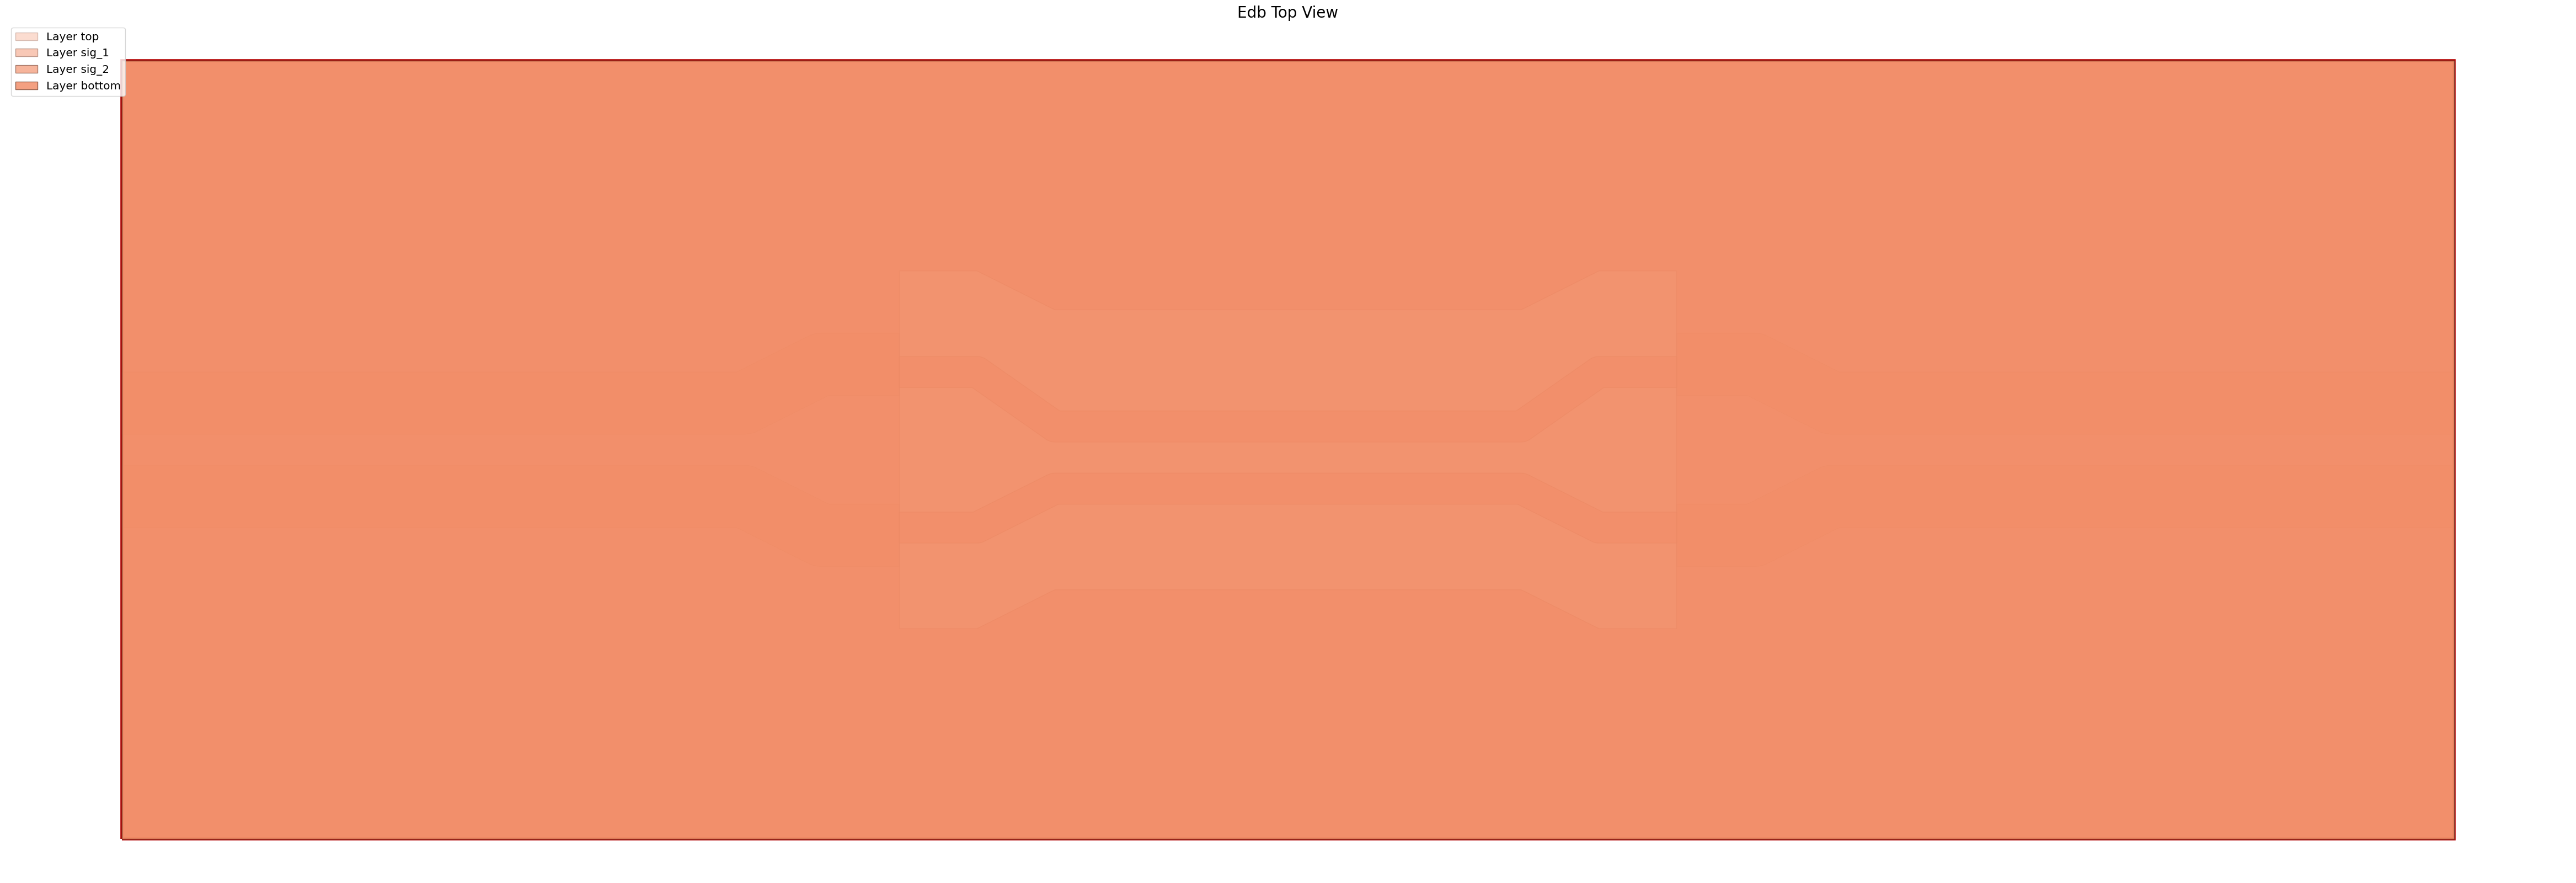

In [23]:
edb.nets.plot(None)

Save the EDB.

In [24]:
edb.save_edb()
edb.close_edb()

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 15.69ms


True

Open the project in HFSS 3D Layout.

In [25]:
h3d = ansys.aedt.core.Hfss3dLayout(
    project=aedb_path,
    version=edb_version,
    non_graphical=non_graphical,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.14.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_67629dda-fd75-4b3e-968a-31f669ae2354.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 54459


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 11576.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmpsozojr_r.ansys\pcb.aedb has been imported to project pcb


PyAEDT INFO: Active Design set to 0;Cell_RDF8VC


PyAEDT INFO: Aedt Objects correctly read


## Add HFSS simulation setup

Add HFSS simulation setup.

In [26]:
setup = h3d.create_setup()
setup.props["AdaptiveSettings"]["SingleFrequencyDataList"]["AdaptiveFrequencyData"]["MaxPasses"] = 3

h3d.create_linear_count_sweep(
    setup=setup.name,
    unit="GHz",
    start_frequency=0,
    stop_frequency=10,
    num_of_freq_points=1001,
    name="sweep1",
    sweep_type="Interpolating",
    interpolation_tol_percent=1,
    interpolation_max_solutions=255,
    save_fields=False,
    use_q3d_for_dc=False,
)

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpsozojr_r.ansys/pcb.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpsozojr_r.ansys/pcb.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015671730041503906


PyAEDT INFO: Linear count sweep sweep1 has been correctly created.


Define the differential pairs to used to calculate differential and common mode
s-parameters.

In [27]:
h3d.set_differential_pair(differential_mode="In", assignment=pos_p1, reference=neg_p1)
h3d.set_differential_pair(differential_mode="Out", assignment=pos_p2, reference=neg_p2)

True

Solve the project.

In [28]:
h3d.analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 28.0s


True

Plot the results and shut down AEDT.

PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


PyAEDT INFO: Desktop has been released and closed.


True

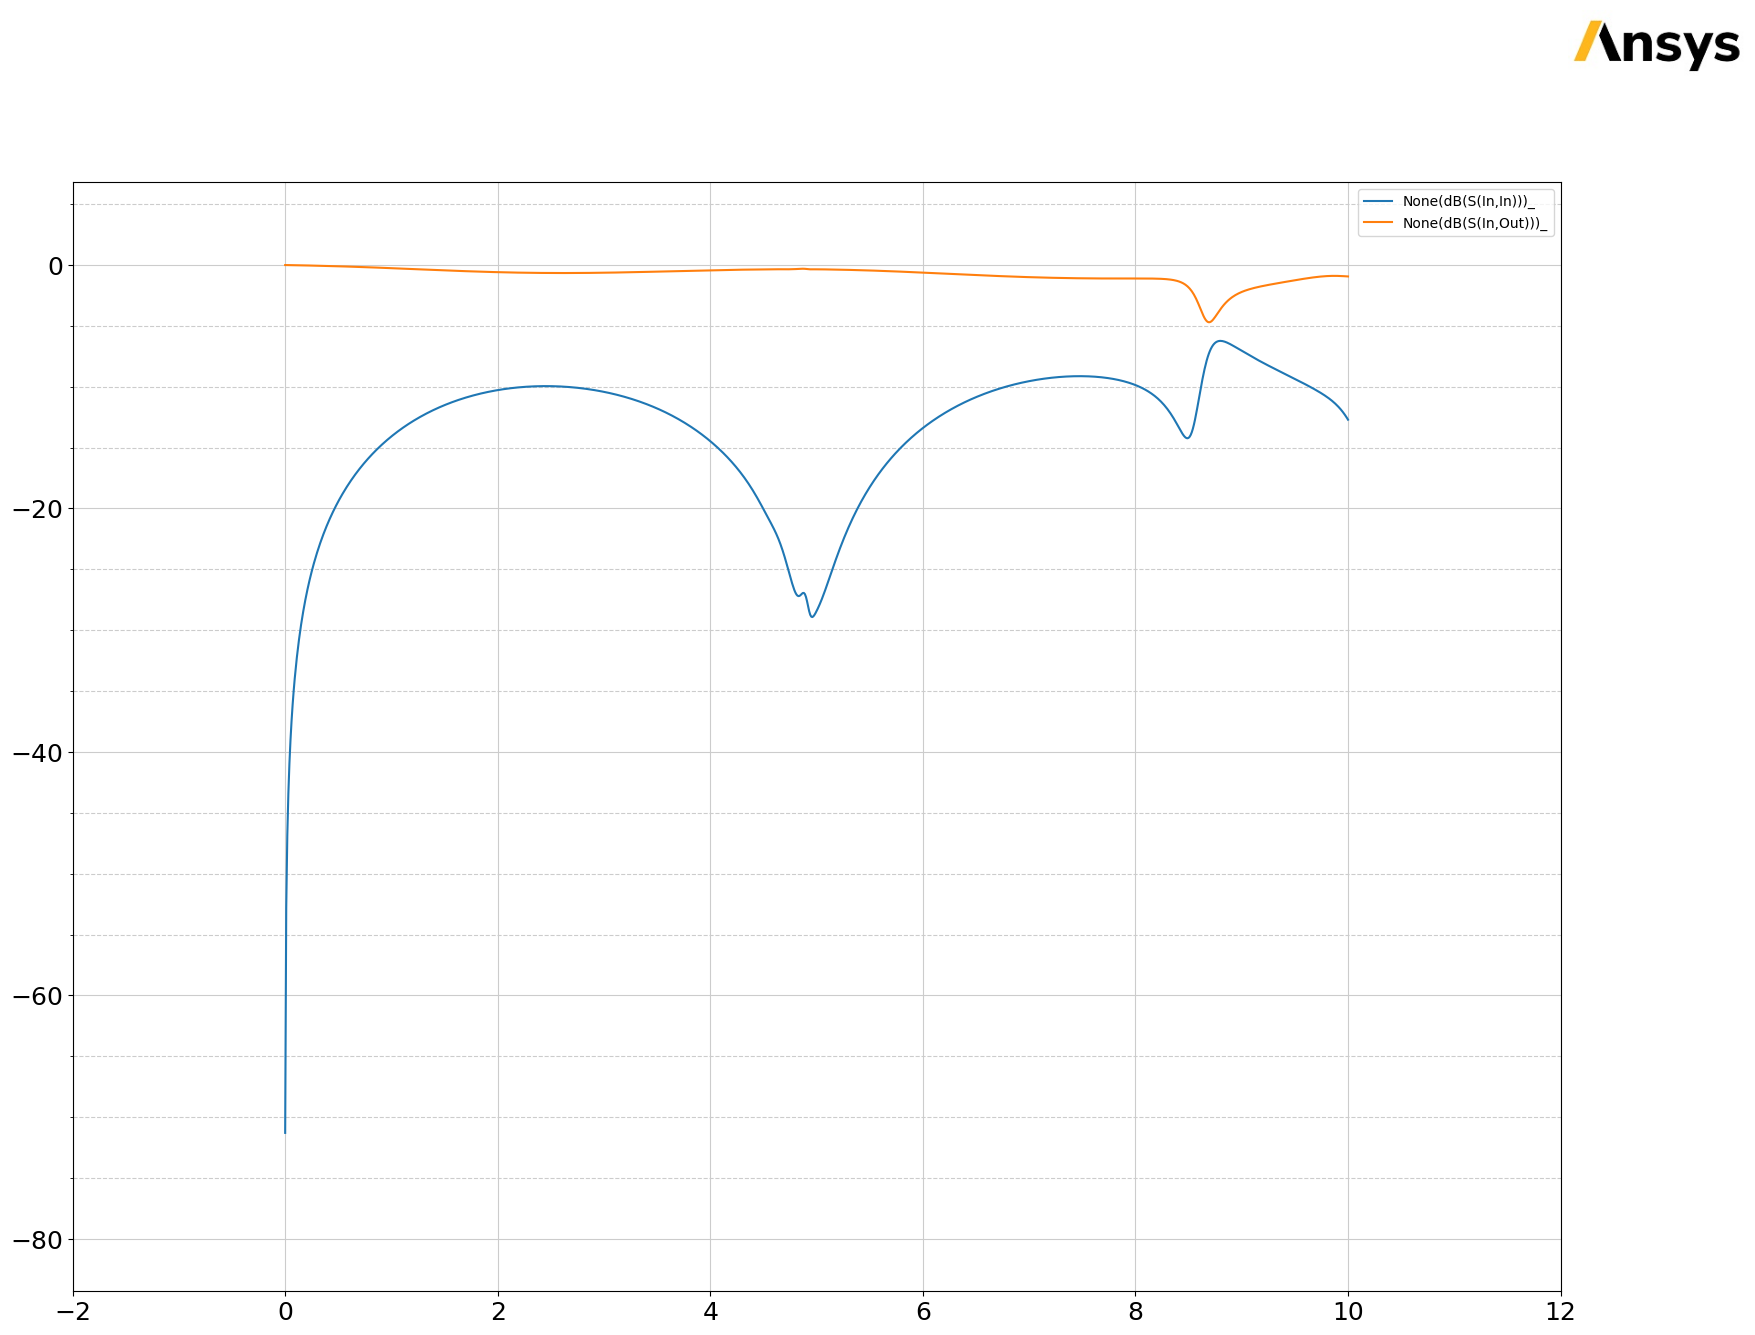

In [29]:
solutions = h3d.post.get_solution_data(["dB(S(In,In))", "dB(S(In,Out))"], context="Differential Pairs")
solutions.plot()
h3d.release_desktop()

Note that the ground nets are only connected to each other due
to the wave ports. The problem with poor grounding can be seen in the
S-parameters. This example can be downloaded as a Jupyter Notebook, so
you can modify it. Try changing parameters or adding ground vias to improve performance.

The final cell cleans up the temporary directory, removing all files.

In [30]:
temp_dir.cleanup()